In [1]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip install tensorflow

#MULTI CLASSIFICATION

> data :  rm1000/lung-cancer-histopathological-images


In [ ]:
!kaggle datasets download rm1000/lung-cancer-histopathological-images

In [ ]:
!unzip /content/lung-cancer-histopathological-images.zip -d data

In [18]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense ,Flatten,Dropout
from tensorflow.keras.optimizers import Adamax, Adam, SGD, RMSprop
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
# import talos
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

In [6]:
data_dir = "/content/data"
image_data = [
    {"image_path": image_file, "label": label}
    for label in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, label))
    for image_file in glob(os.path.join(data_dir, label, "*.jpg"))
]

lung_df = pd.DataFrame(image_data)

In [ ]:
lung_df.head()

,image_path,label
0,/content/data/adenocarcinoma/4804.jpg,adenocarcinoma
1,/content/data/adenocarcinoma/0180.jpg,adenocarcinoma
2,/content/data/adenocarcinoma/3694.jpg,adenocarcinoma
3,/content/data/adenocarcinoma/3915.jpg,adenocarcinoma
4,/content/data/adenocarcinoma/3767.jpg,adenocarcinoma


In [ ]:
lung_df.describe()

,image_path,label
count,15000,15000
unique,15000,3
top,/content/data/adenocarcinoma/4804.jpg,adenocarcinoma
freq,1,5000


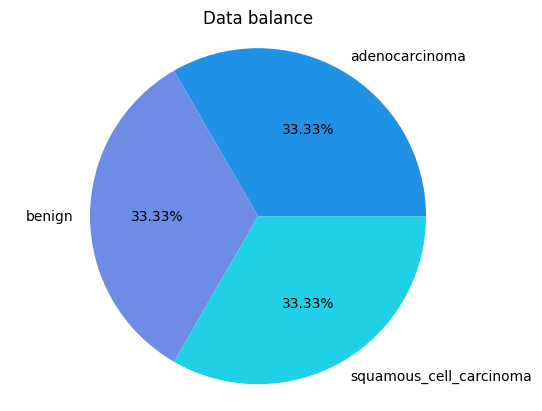

In [ ]:
data_balance = lung_df.label.value_counts()
plt.pie(data_balance, labels = data_balance.index, autopct='%1.2f%%', colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Data balance")
plt.axis("equal")
plt.show()

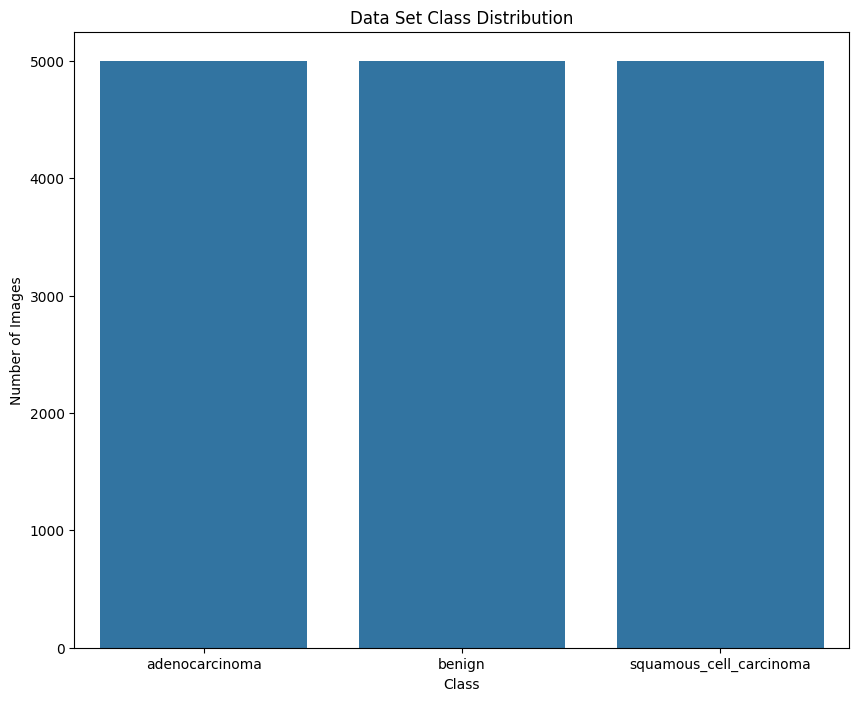

In [ ]:
plt.subplots(figsize=(10,8))
sns.countplot(data=lung_df,x="label")
plt.title('Data Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [ ]:
# lung_key = {'adenocarcinoma' : 1, 'benign' : 0,'squamous_cell_carcinoma' : 2}

# lung_df['label'] = lung_df['label'].map(lung_key)
# lung_df.head(10)

In [7]:
train_df, test_df = train_test_split(lung_df, test_size = 0.1, shuffle = True, random_state = 42,stratify=lung_df['label'])
train_df, valid_df = train_test_split(train_df, test_size = 0.2, shuffle = True, random_state = 42,stratify=train_df['label'])

print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (10800, 2)
Validation set shape: (2700, 2)
Testing set shape: (1500, 2)


In [8]:
train_class_counts = train_df['label'].value_counts().sort_index()
print("Training Set Class Distribution:")
print(train_class_counts)

valid_class_counts = valid_df['label'].value_counts().sort_index()
print("\nValidation Set Class Distribution:")
print(valid_class_counts)

test_class_counts = test_df['label'].value_counts().sort_index()
print("\nTest Set Class Distribution:")
print(test_class_counts)

Training Set Class Distribution:
label
adenocarcinoma             3600
benign                     3600
squamous_cell_carcinoma    3600
Name: count, dtype: int64

Validation Set Class Distribution:
label
adenocarcinoma             900
benign                     900
squamous_cell_carcinoma    900
Name: count, dtype: int64

Test Set Class Distribution:
label
adenocarcinoma             500
benign                     500
squamous_cell_carcinoma    500
Name: count, dtype: int64


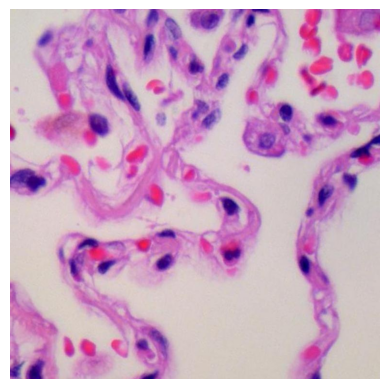

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sample_image_path = train_df['image_path'].iloc[0]

img = mpimg.imread(sample_image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [9]:
batch_size = 32
img_size = (224, 224)
tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'image_path', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'image_path', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'image_path', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 10800 validated image filenames belonging to 3 classes.
Found 2700 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


In [11]:
def model_performance(history, Epochs):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'b', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'b', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [12]:
def print_confusion_matrix(model, test_gen):
  y_true = test_gen.classes
  y_pred = model.predict(test_gen)
  y_pred = np.argmax(y_pred, axis=1)
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()

In [13]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

### model - 1

In [14]:

model = Sequential()
model.add(Input(shape=img_shape))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(class_counts, activation = 'softmax'))

model.compile(Adam(learning_rate= 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

history=model.fit(train_gen, epochs= 30, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


338/338 ━━━━━━━━━━━━━━━━━━━━ 66s 186ms/step - accuracy: 0.5725 - loss: 14.6877 - val_accuracy: 0.6411 - val_loss: 3.6482
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 84s 198ms/step - accuracy: 0.7211 - loss: 1.3697 - val_accuracy: 0.6030 - val_loss: 1.1649
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 57s 169ms/step - accuracy: 0.7198 - loss: 0.7982 - val_accuracy: 0.7863 - val_loss: 0.4373
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 59s 174ms/step - accuracy: 0.7587 - loss: 0.4951 - val_accuracy: 0.7063 - val_loss: 0.5796
Epoch 5/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 56s 166ms/step - accuracy: 0.7567 - loss: 0.5040 - val_accuracy: 0.7526 - val_loss: 0.4797
Epoch 6/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 68s 202ms/step - accuracy: 0.7713 - loss: 0.4653 - val_accuracy: 0.7956 - val_loss: 0.4308
Epoch 7/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 59s 173ms/step - accuracy: 0.7587 - loss: 0.4875 - val_accuracy: 0.7674 - val_loss: 0.4741
Epoch 8/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 58s 171ms/step - accuracy: 0.7622 - loss: 0.4867 - va

In [26]:
loss, accuracy = model.evaluate(test_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {loss}')

Model Accuracy : 75%
Model Loss : 0.4866454601287842


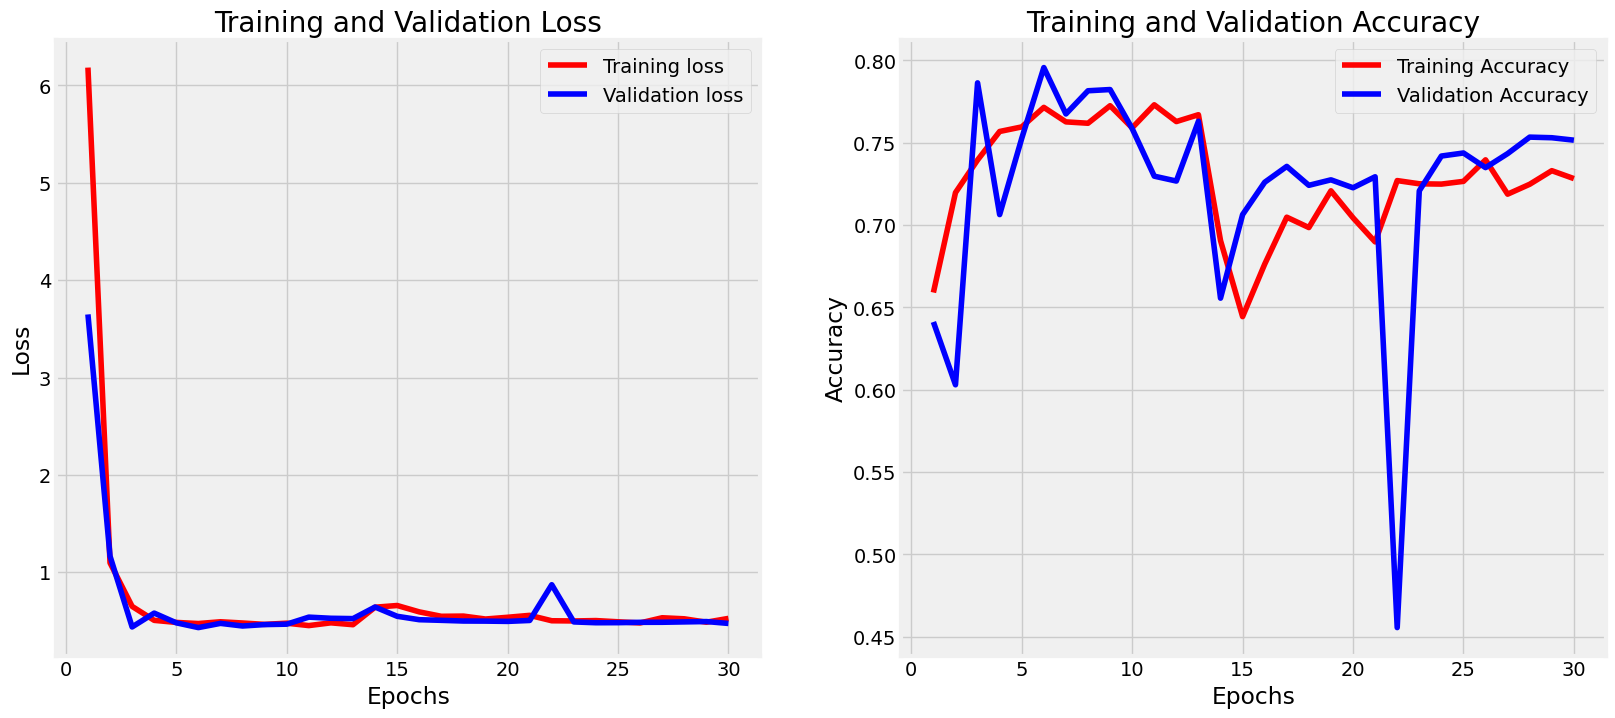

In [17]:
model_performance(history, 30)

### model - 2

In [19]:
K.clear_session()
model = Sequential()
model.add(Input(shape=img_shape))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(class_counts, activation = 'softmax'))

# توقف  تدريب اذا لم يحدث تحسن استعملناها بسبب وجود تخصيص ذائد عند التدريب على عدد عصور كبير فهذه توقف التدريب بعد خمس عصور من عدم تقدم المودل وتحتفظ بافضل الاوزان
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
model.compile(Adam(learning_rate= 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

history=model.fit(train_gen, epochs= 30, verbose= 1, validation_data= valid_gen, shuffle= False,callbacks=[early_stopping])

Epoch 1/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - accuracy: 0.6034 - loss: 5.9575 - val_accuracy: 0.6656 - val_loss: 1.2774
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 60s 179ms/step - accuracy: 0.7365 - loss: 0.7217 - val_accuracy: 0.6867 - val_loss: 0.6191
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 66s 196ms/step - accuracy: 0.7555 - loss: 0.4980 - val_accuracy: 0.7256 - val_loss: 0.5912
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 73s 217ms/step - accuracy: 0.7535 - loss: 0.5135 - val_accuracy: 0.7407 - val_loss: 0.5852
Epoch 5/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 58s 171ms/step - accuracy: 0.7422 - loss: 0.5002 - val_accuracy: 0.6922 - val_loss: 0.5008
Epoch 6/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 59s 173ms/step - accuracy: 0.7394 - loss: 0.5008 - val_accuracy: 0.7544 - val_loss: 0.5022
Epoch 7/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 66s 195ms/step - accuracy: 0.7724 - loss: 0.4671 - val_accuracy: 0.7648 - val_loss: 0.5022
Epoch 8/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 60s 176ms/step - accuracy: 0.7782 - loss: 0

In [27]:
loss, accuracy = model.evaluate(test_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {loss}')

Model Accuracy : 76%
Model Loss : 0.4548681378364563


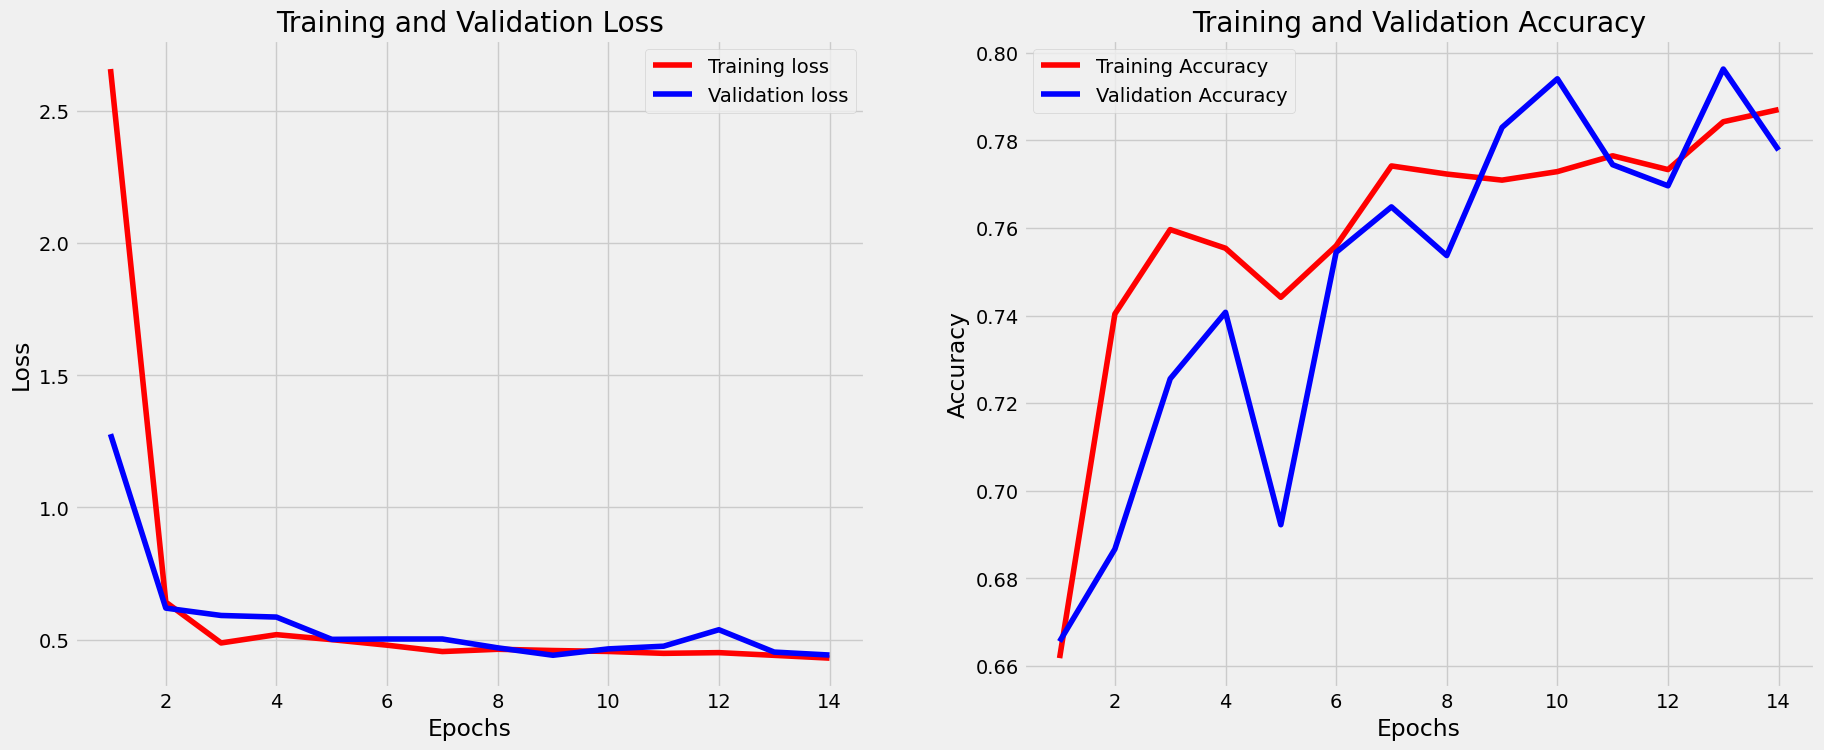

In [22]:
model_performance(history, 20)

### model - 3

In [23]:
K.clear_session()
model = Sequential()
model.add(Input(shape=img_shape))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(class_counts, activation = 'softmax'))


model.compile(Adam(learning_rate= 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
history=model.fit(train_gen, epochs= 30, verbose= 1, validation_data= valid_gen, shuffle= False,callbacks=[early_stopping])

Epoch 1/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 65s 185ms/step - accuracy: 0.6004 - loss: 3.2095 - val_accuracy: 0.7759 - val_loss: 0.5488
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 58s 172ms/step - accuracy: 0.7152 - loss: 0.8677 - val_accuracy: 0.6896 - val_loss: 0.9290
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 54s 161ms/step - accuracy: 0.7418 - loss: 0.6786 - val_accuracy: 0.7707 - val_loss: 0.5041
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 58s 171ms/step - accuracy: 0.7500 - loss: 0.6229 - val_accuracy: 0.7911 - val_loss: 0.4288
Epoch 5/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 55s 163ms/step - accuracy: 0.7455 - loss: 0.5344 - val_accuracy: 0.7237 - val_loss: 0.4999
Epoch 6/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 56s 165ms/step - accuracy: 0.7720 - loss: 0.4457 - val_accuracy: 0.7811 - val_loss: 0.4546
Epoch 7/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 55s 164ms/step - accuracy: 0.7758 - loss: 0.4493 - val_accuracy: 0.7526 - val_loss: 0.4777
Epoch 8/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 56s 165ms/step - accuracy: 0.7894 - loss: 0

In [28]:
loss, accuracy = model.evaluate(test_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {loss}')

Model Accuracy : 78%
Model Loss : 0.43926891684532166


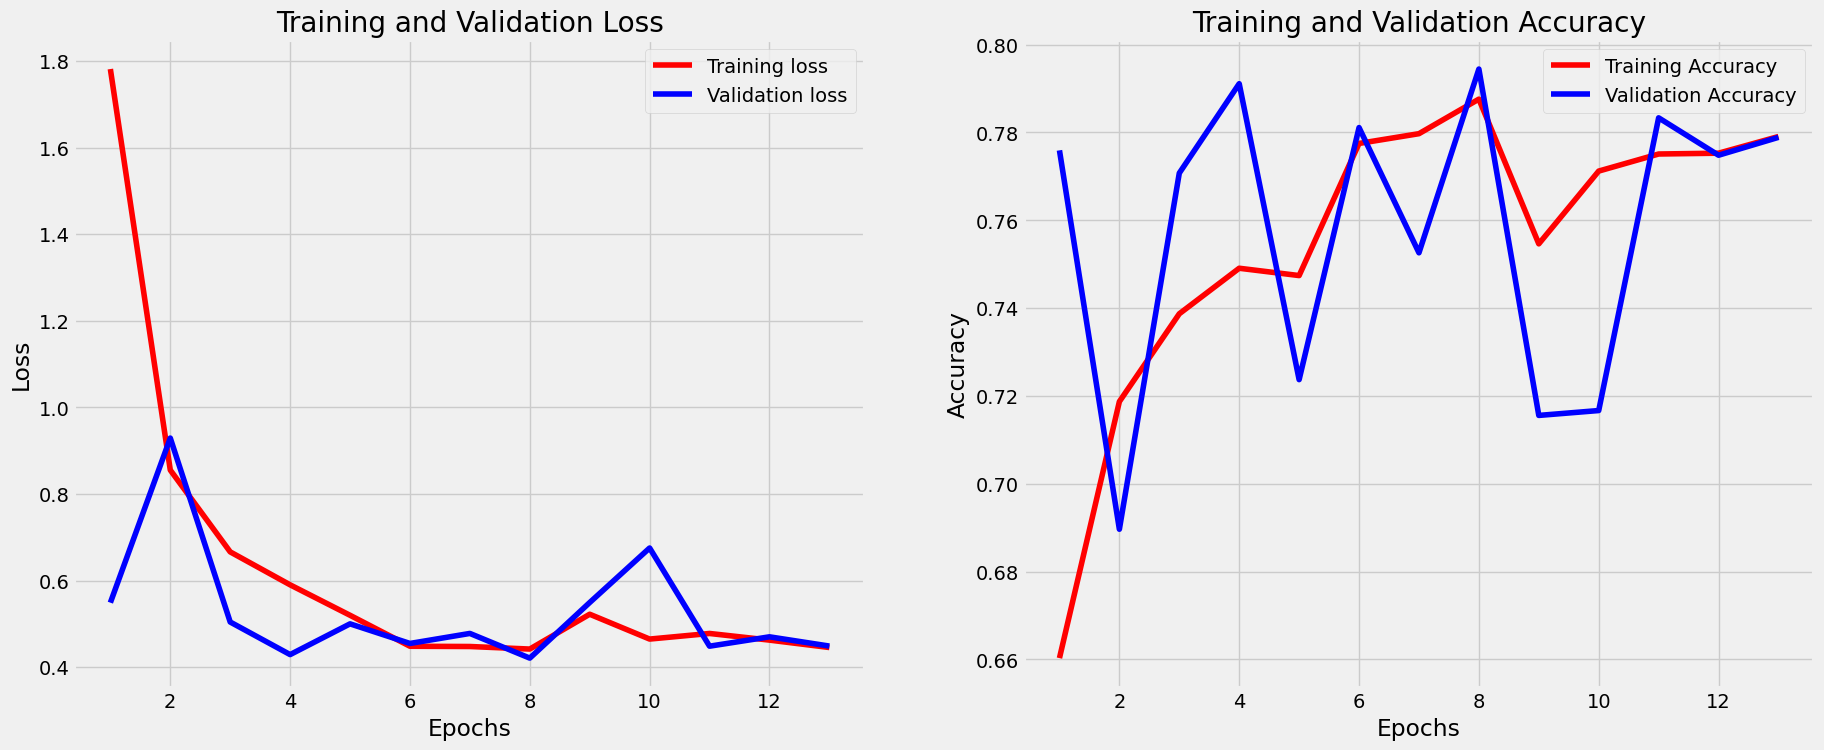

In [29]:
model_performance(history, 20)

### model - 4

In [30]:
K.clear_session()

model = Sequential()
model.add(Input(shape=img_shape))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(class_counts, activation = 'softmax'))

model.compile(Adam(learning_rate= 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history=model.fit(train_gen, epochs= 30, verbose= 1, validation_data= valid_gen, shuffle= False,callbacks=[early_stopping])

Epoch 1/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 64s 183ms/step - accuracy: 0.5700 - loss: 4.8705 - val_accuracy: 0.7596 - val_loss: 0.5799
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 65s 191ms/step - accuracy: 0.7198 - loss: 1.0761 - val_accuracy: 0.7267 - val_loss: 0.6768
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 55s 163ms/step - accuracy: 0.7362 - loss: 0.7667 - val_accuracy: 0.7811 - val_loss: 0.4708
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 56s 166ms/step - accuracy: 0.7809 - loss: 0.5067 - val_accuracy: 0.7015 - val_loss: 0.6627
Epoch 5/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 56s 166ms/step - accuracy: 0.7666 - loss: 0.5020 - val_accuracy: 0.7904 - val_loss: 0.4341
Epoch 6/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 57s 168ms/step - accuracy: 0.7703 - loss: 0.5008 - val_accuracy: 0.7496 - val_loss: 0.4906
Epoch 7/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 65s 194ms/step - accuracy: 0.7906 - loss: 0.4312 - val_accuracy: 0.7800 - val_loss: 0.5451
Epoch 8/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 58s 170ms/step - accuracy: 0.7685 - loss: 0

In [31]:
loss, accuracy = model.evaluate(test_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {loss}')

Model Accuracy : 76%
Model Loss : 0.45856815576553345


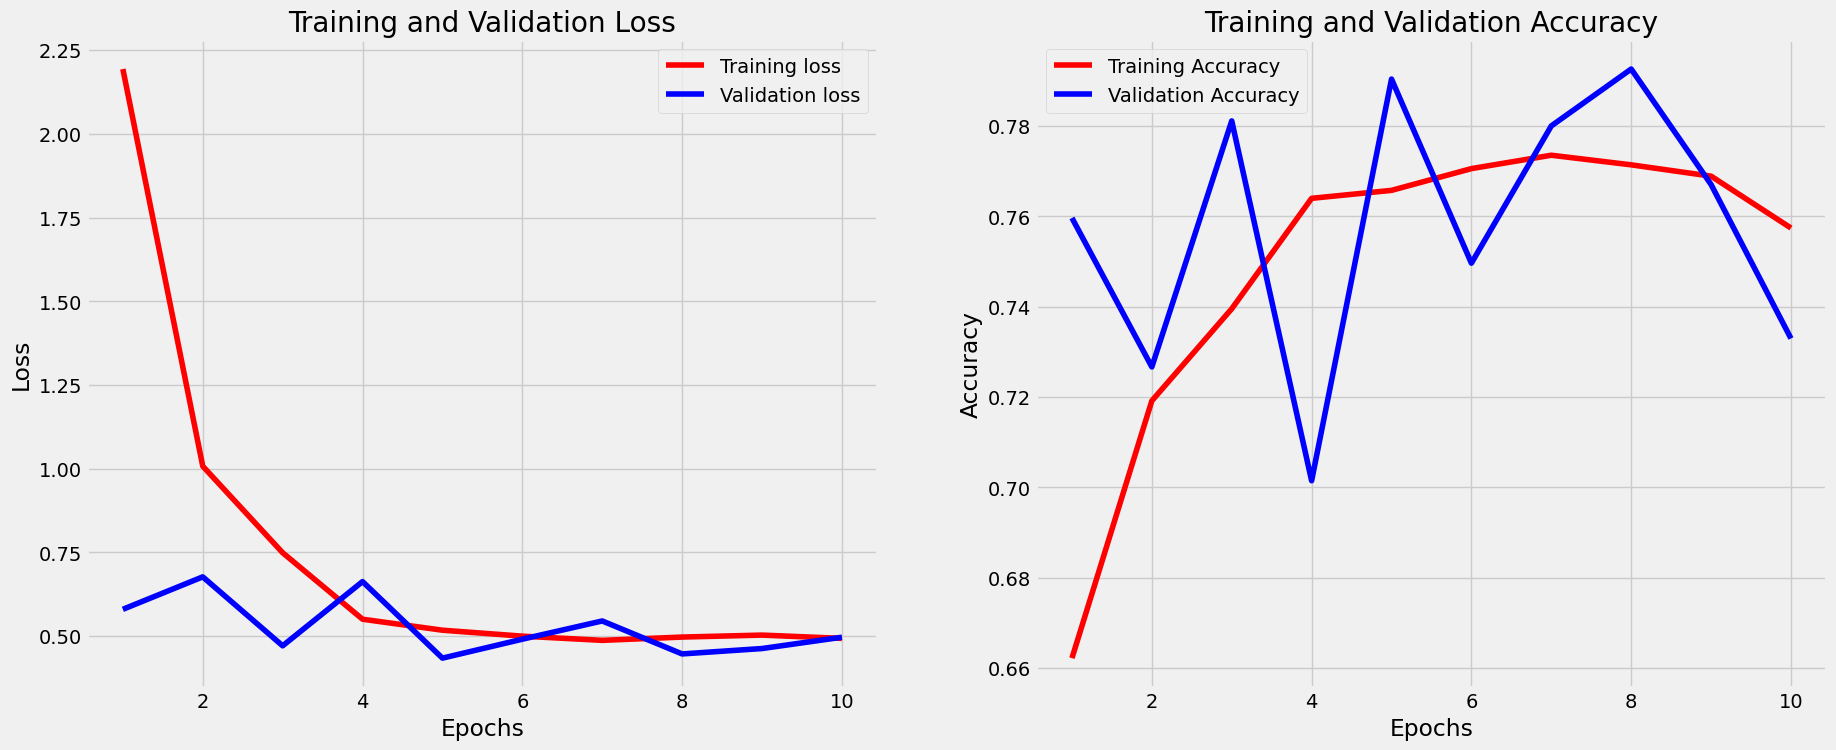

In [32]:
model_performance(history, 20)

### model - 5

In [33]:
K.clear_session()

model = Sequential()
model.add(Input(shape=img_shape))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(class_counts, activation = 'softmax'))

model.compile(Adam(learning_rate= 0.01),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history=model.fit(train_gen, epochs= 30, verbose= 1, validation_data= valid_gen, shuffle= False,callbacks=[early_stopping])

Epoch 1/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 64s 184ms/step - accuracy: 0.3410 - loss: 60.1347 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 56s 167ms/step - accuracy: 0.3360 - loss: 1.0989 - val_accuracy: 0.3333 - val_loss: 1.0994
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 59s 175ms/step - accuracy: 0.3321 - loss: 1.0988 - val_accuracy: 0.3333 - val_loss: 1.0998
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 78s 165ms/step - accuracy: 0.3304 - loss: 1.0994 - val_accuracy: 0.3333 - val_loss: 1.0992


In [34]:
loss, accuracy = model.evaluate(test_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {loss}')

Model Accuracy : 33%
Model Loss : 1.0986162424087524


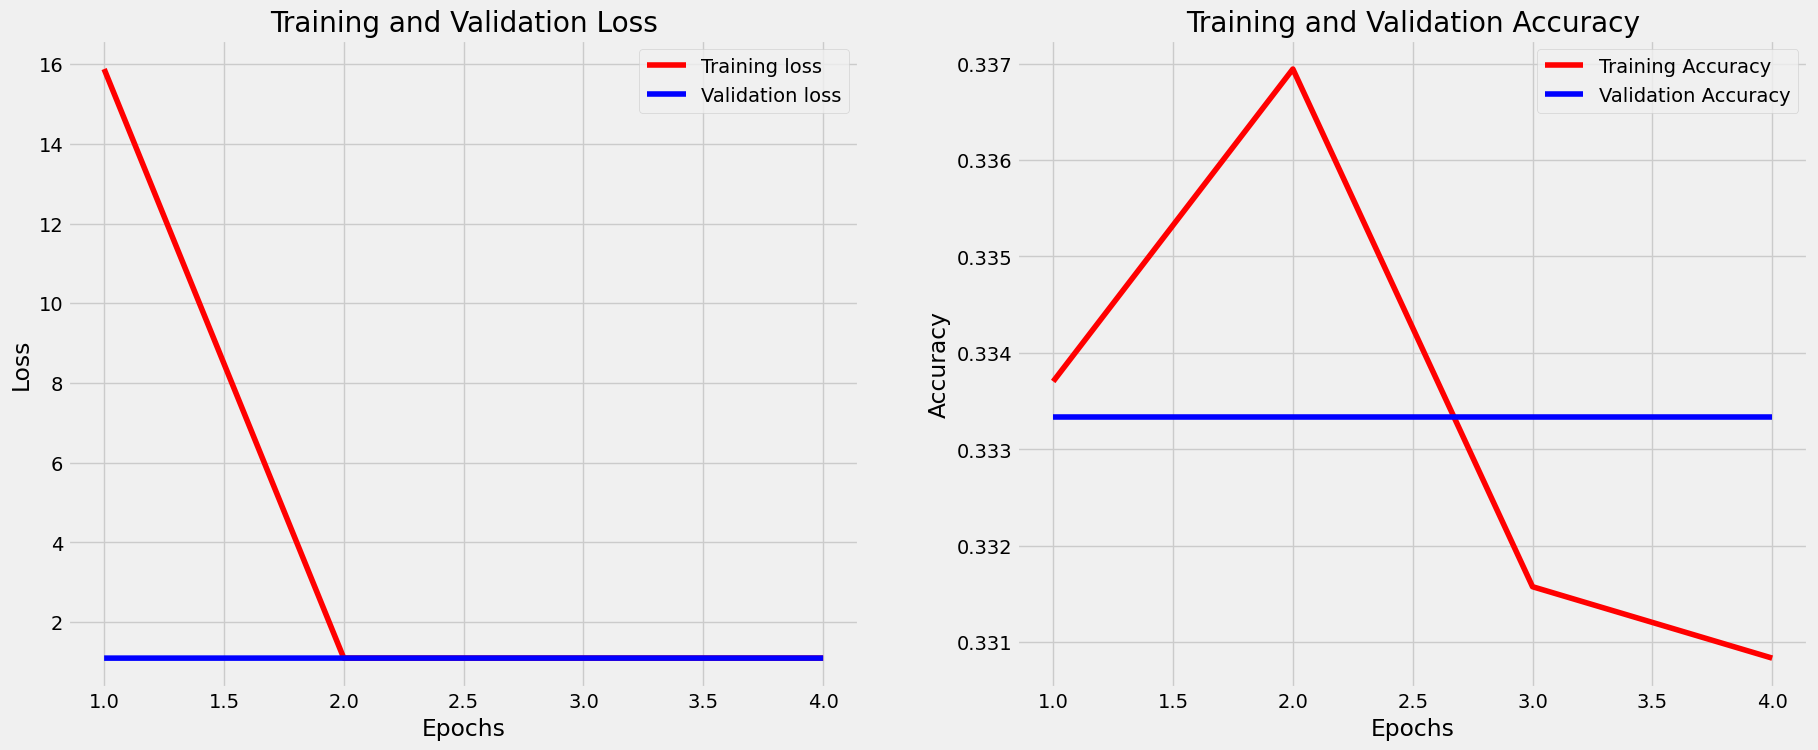

In [35]:
model_performance(history, 10)

### model - 6

In [36]:
K.clear_session()

model = Sequential()
model.add(Input(shape=img_shape))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(class_counts, activation = 'softmax'))

model.compile(Adamax(learning_rate= 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history=model.fit(train_gen, epochs= 10, verbose= 1, validation_data= valid_gen, shuffle= False,callbacks=[early_stopping])

Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 79s 229ms/step - accuracy: 0.6122 - loss: 4.9291 - val_accuracy: 0.7541 - val_loss: 0.4711
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 67s 198ms/step - accuracy: 0.7484 - loss: 0.5447 - val_accuracy: 0.7000 - val_loss: 0.6035
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 68s 203ms/step - accuracy: 0.7459 - loss: 0.5300 - val_accuracy: 0.7915 - val_loss: 0.4418
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 58s 171ms/step - accuracy: 0.7494 - loss: 0.5631 - val_accuracy: 0.7648 - val_loss: 0.4863
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 56s 166ms/step - accuracy: 0.7367 - loss: 0.5998 - val_accuracy: 0.7993 - val_loss: 0.4281
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 56s 164ms/step - accuracy: 0.7638 - loss: 0.5108 - val_accuracy: 0.6952 - val_loss: 0.6771
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 57s 169ms/step - accuracy: 0.7556 - loss: 0.5293 - val_accuracy: 0.7948 - val_loss: 0.5250
Epoch 8/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 56s 165ms/step - accuracy: 0.7583 - loss: 0

In [38]:
loss, accuracy = model.evaluate(test_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {loss}')

Model Accuracy : 78%
Model Loss : 0.44860270619392395


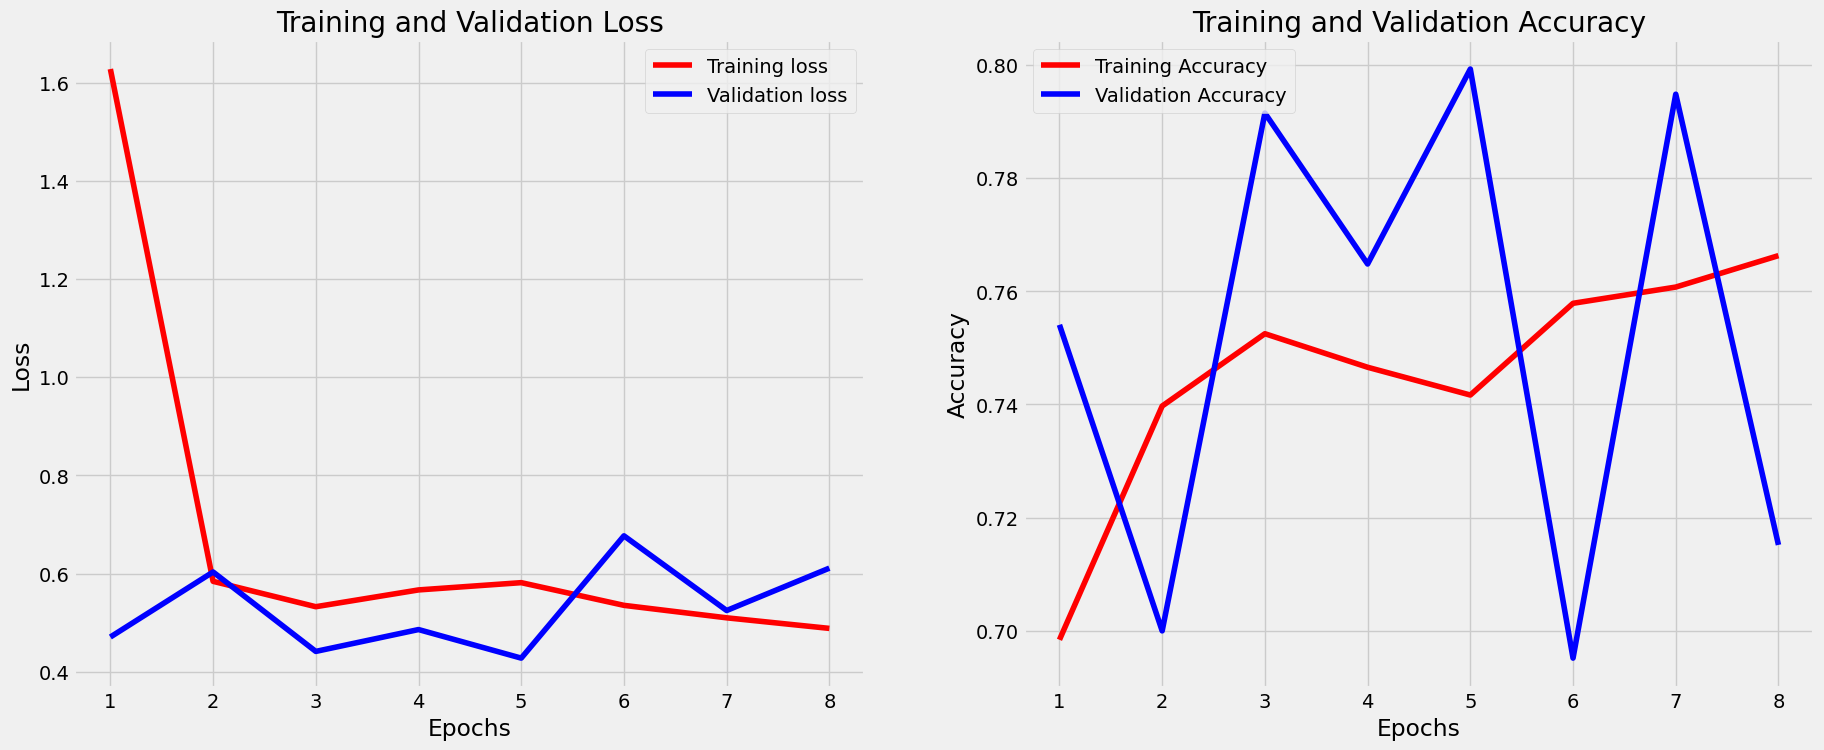

In [39]:
model_performance(history, 10)

### model - 7

In [40]:
K.clear_session()

model = Sequential()
model.add(Input(shape=img_shape))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(class_counts, activation = 'softmax'))

model.compile(SGD(learning_rate= 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history=model.fit(train_gen, epochs= 30, verbose= 1, validation_data= valid_gen, shuffle= False,callbacks=[early_stopping])

Epoch 1/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 66s 191ms/step - accuracy: 0.5932 - loss: 0.7730 - val_accuracy: 0.7215 - val_loss: 0.5269
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 56s 167ms/step - accuracy: 0.7291 - loss: 0.5075 - val_accuracy: 0.6907 - val_loss: 0.5604
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 56s 166ms/step - accuracy: 0.7425 - loss: 0.4847 - val_accuracy: 0.7630 - val_loss: 0.4563
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 81s 162ms/step - accuracy: 0.7519 - loss: 0.4791 - val_accuracy: 0.7596 - val_loss: 0.4707
Epoch 5/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 55s 163ms/step - accuracy: 0.7591 - loss: 0.4654 - val_accuracy: 0.7685 - val_loss: 0.4537
Epoch 6/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 57s 168ms/step - accuracy: 0.7653 - loss: 0.4563 - val_accuracy: 0.7744 - val_loss: 0.4456
Epoch 7/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 80s 162ms/step - accuracy: 0.7721 - loss: 0.4491 - val_accuracy: 0.7774 - val_loss: 0.4401
Epoch 8/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 65s 193ms/step - accuracy: 0.7781 - loss: 0

In [41]:
loss, accuracy = model.evaluate(test_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {loss}')

Model Accuracy : 77%
Model Loss : 0.43883708119392395


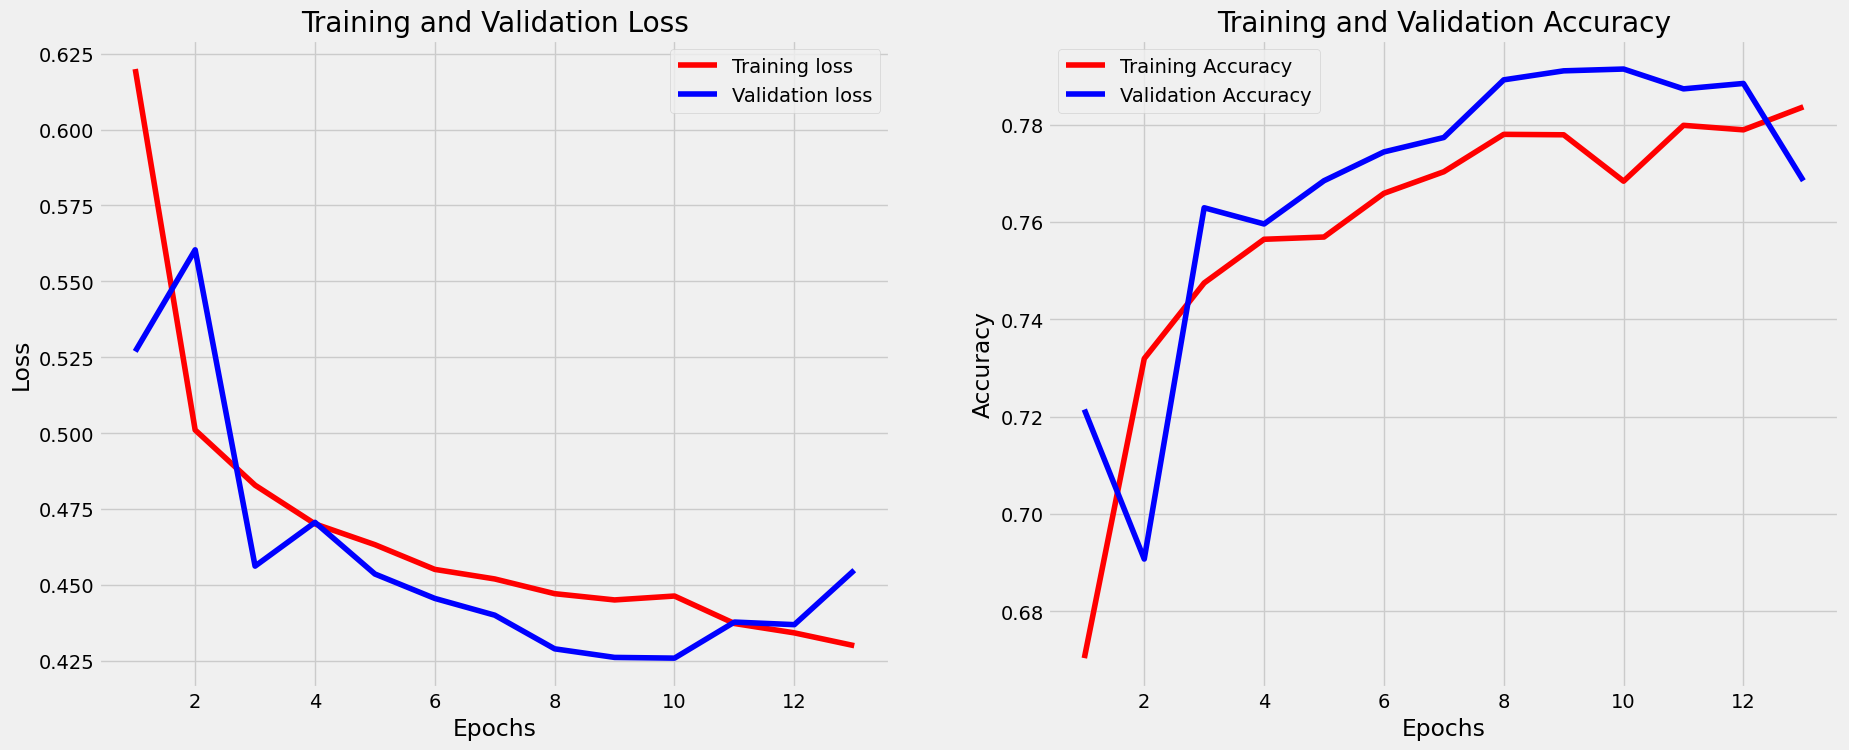

In [43]:
model_performance(history, 20)

### model - 8

In [49]:
K.clear_session()

model = Sequential()
model.add(Input(shape=img_shape))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(class_counts, activation = 'softmax'))

model.compile(Adam(learning_rate= 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history=model.fit(train_gen, epochs= 50, verbose= 1, validation_data= valid_gen, shuffle= False,callbacks=[early_stopping])

Epoch 1/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 67s 187ms/step - accuracy: 0.4843 - loss: 8.0662 - val_accuracy: 0.6444 - val_loss: 0.7095
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 56s 167ms/step - accuracy: 0.6227 - loss: 0.6940 - val_accuracy: 0.6485 - val_loss: 0.5634
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 66s 195ms/step - accuracy: 0.6111 - loss: 0.6462 - val_accuracy: 0.6452 - val_loss: 0.5896
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 56s 165ms/step - accuracy: 0.5889 - loss: 0.7274 - val_accuracy: 0.6437 - val_loss: 0.5927
Epoch 5/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 58s 172ms/step - accuracy: 0.5803 - loss: 0.7344 - val_accuracy: 0.6407 - val_loss: 0.6200
Epoch 6/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 56s 165ms/step - accuracy: 0.5792 - loss: 0.7287 - val_accuracy: 0.6444 - val_loss: 0.5927
Epoch 7/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 59s 174ms/step - accuracy: 0.5886 - loss: 0.7235 - val_accuracy: 0.6485 - val_loss: 0.5870
Epoch 8/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 55s 162ms/step - accuracy: 0.5797 - loss: 0

In [50]:
loss, accuracy = model.evaluate(test_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {loss}')

Model Accuracy : 65%
Model Loss : 0.5722606778144836


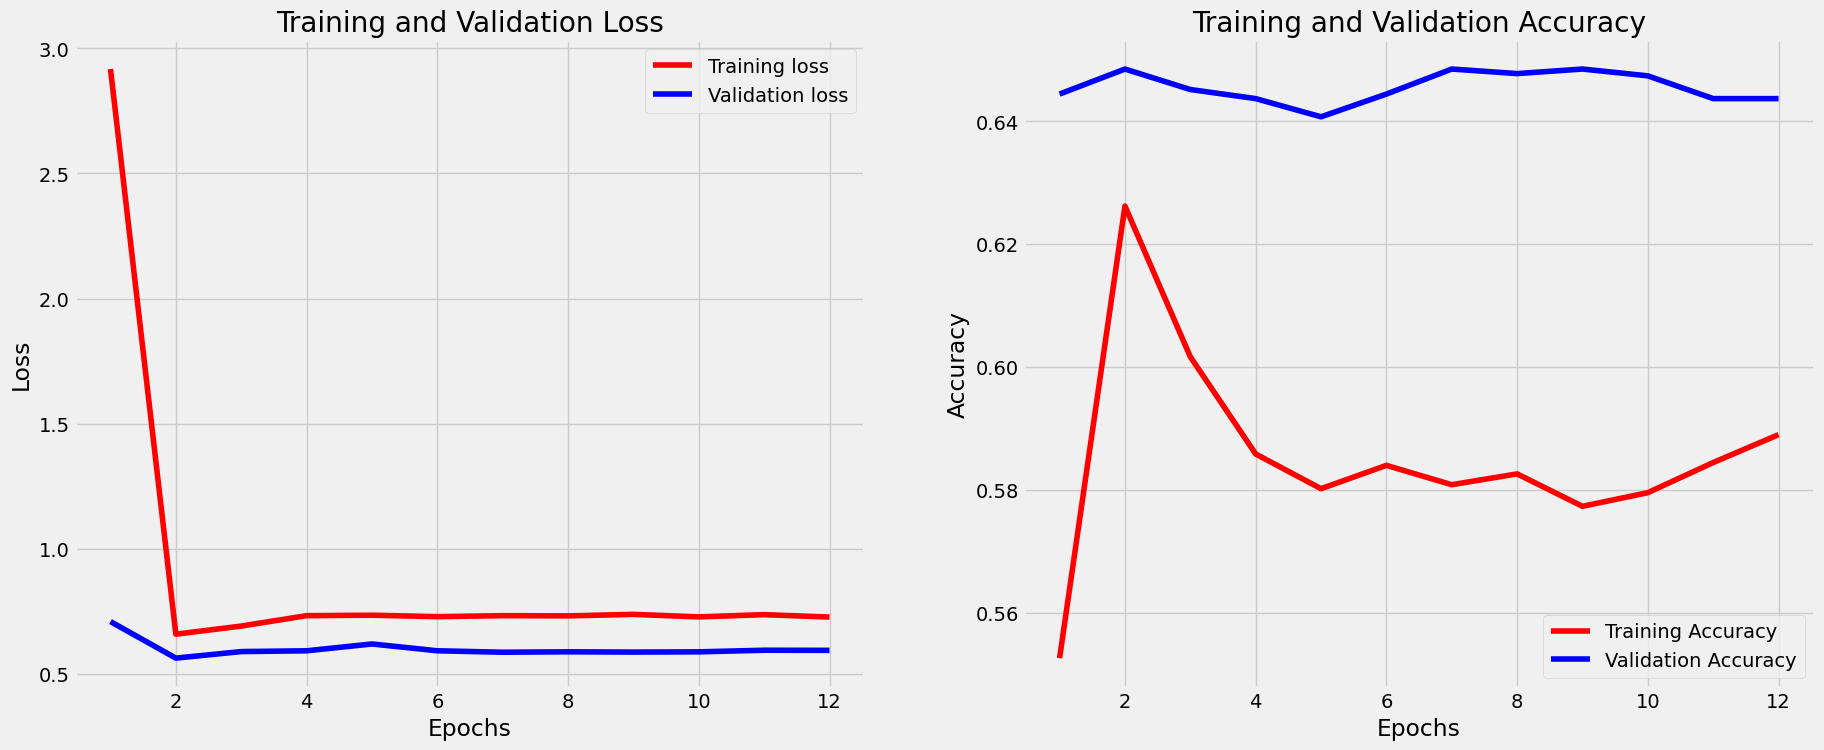

In [51]:
model_performance(history, 20)

### model - 9

In [52]:

K.clear_session()

model = Sequential()
model.add(Input(shape=img_shape))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(class_counts, activation = 'softmax'))

model.compile(Adam(learning_rate= 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history=model.fit(train_gen, epochs= 50, verbose= 1, validation_data= valid_gen, shuffle= False,callbacks=[early_stopping])

Epoch 1/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 84s 235ms/step - accuracy: 0.5358 - loss: 8.0398 - val_accuracy: 0.7641 - val_loss: 0.4924
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 58s 173ms/step - accuracy: 0.7174 - loss: 0.6618 - val_accuracy: 0.7919 - val_loss: 0.4316
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 59s 173ms/step - accuracy: 0.7486 - loss: 0.5102 - val_accuracy: 0.7633 - val_loss: 0.4566
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 57s 168ms/step - accuracy: 0.7437 - loss: 0.5150 - val_accuracy: 0.7867 - val_loss: 0.4442
Epoch 5/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 59s 174ms/step - accuracy: 0.7633 - loss: 0.4675 - val_accuracy: 0.7859 - val_loss: 0.4589
Epoch 6/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 56s 167ms/step - accuracy: 0.7574 - loss: 0.4890 - val_accuracy: 0.7044 - val_loss: 0.4898
Epoch 7/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 93s 200ms/step - accuracy: 0.7600 - loss: 0.4823 - val_accuracy: 0.7467 - val_loss: 0.5280
Epoch 8/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 55s 162ms/step - accuracy: 0.7437 - loss: 0

In [53]:
loss, accuracy = model.evaluate(test_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {loss}')

Model Accuracy : 77%
Model Loss : 0.4482232928276062


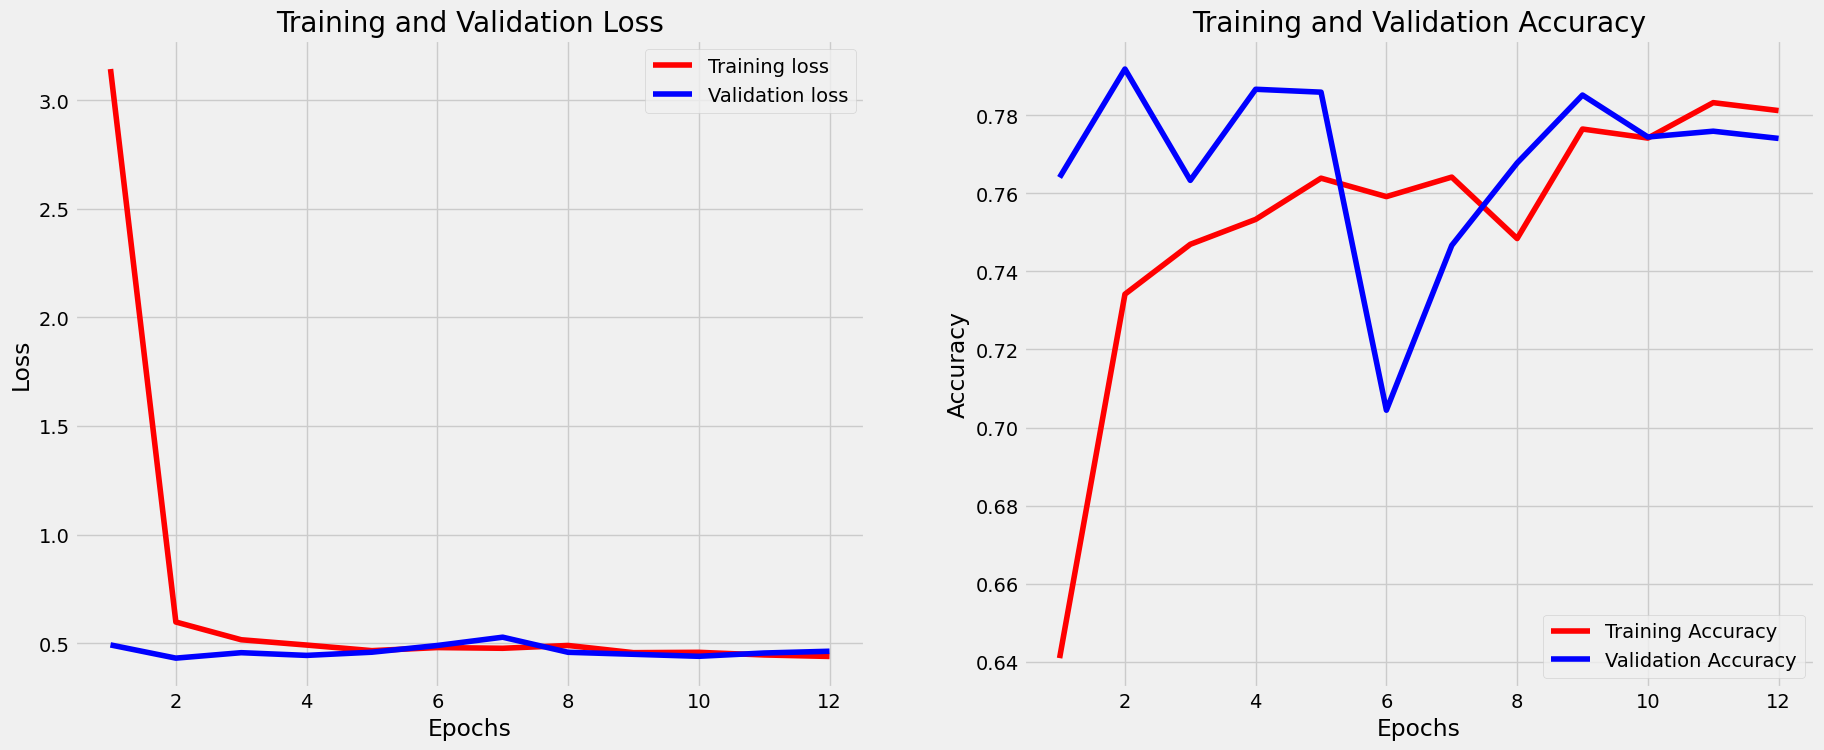

In [54]:
model_performance(history, 20)

### model - 10

In [ ]:
# run this code please >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

K.clear_session()

model = Sequential()
model.add(Input(shape=img_shape))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(class_counts, activation = 'softmax'))

model.compile(Adam(learning_rate= 0.001),loss = 'categorical_crossentropy', metrics = ['accuracy'] )

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history=model.fit(train_gen, epochs= 50, verbose= 1, validation_data= valid_gen, shuffle= False,callbacks=[early_stopping])

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


338/338 ━━━━━━━━━━━━━━━━━━━━ 167s 486ms/step - accuracy: 0.5929 - loss: 5.0614 - val_accuracy: 0.7830 - val_loss: 0.6230
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 160s 474ms/step - accuracy: 0.7171 - loss: 1.0760 - val_accuracy: 0.7578 - val_loss: 0.5580
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 161s 475ms/step - accuracy: 0.7202 - loss: 0.6842 - val_accuracy: 0.7352 - val_loss: 0.5517
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 157s 466ms/step - accuracy: 0.7354 - loss: 0.5718 - val_accuracy: 0.7574 - val_loss: 0.4780
Epoch 5/30
303/338 ━━━━━━━━━━━━━━━━━━━━ 15s 438ms/step - accuracy: 0.7260 - loss: 0.5458

In [ ]:
loss, accuracy = model.evaluate(test_gen, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {loss}')

Model Accuracy : 62%
Model Loss : 86%


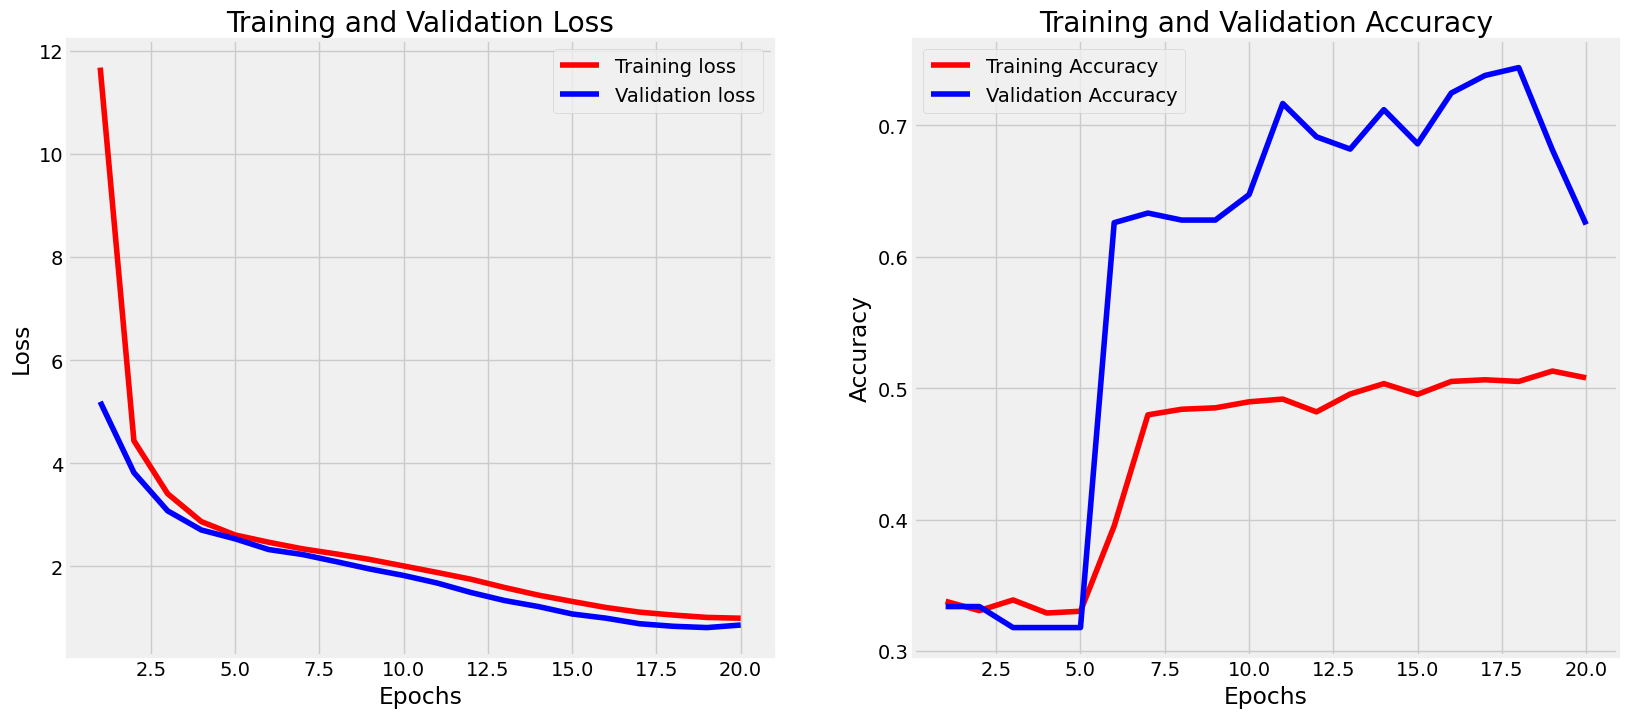

In [ ]:
model_performance(history, 20)

#BINARY CLASSIFICATION


> data :  mysarahmadbhat/lung-cancer



In [ ]:
!kaggle datasets download mysarahmadbhat/lung-cancer

Dataset URL: https://www.kaggle.com/datasets/mysarahmadbhat/lung-cancer
License(s): CC0-1.0
  0% 0.00/2.00k [00:00<?, ?B/s]
100% 2.00k/2.00k [00:00<00:00, 4.62MB/s]


In [ ]:
!unzip lung-cancer.zip -d data

Archive:  lung-cancer.zip
  inflating: data/survey lung cancer.csv  


In [ ]:
df = pd.read_csv('data/survey lung cancer.csv')

In [ ]:
df.describe()

,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,62.673139,1.563107,1.569579,1.498382,1.501618,1.504854,1.673139,1.556634,1.556634,1.556634,1.579288,1.640777,1.469256,1.556634
std,8.210301,0.496806,0.495938,0.500808,0.500808,0.500787,0.469827,0.497588,0.497588,0.497588,0.494474,0.480551,0.499863,0.497588
min,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,57.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,62.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000
75%,69.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,87.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [ ]:
df.duplicated().sum()

33

In [ ]:
# remove duplicated
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [ ]:
df.head(10)

# we need convert gender to number and scale age value

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO
5,F,75,1,2,1,1,2,2,2,2,1,2,2,1,1,YES
6,M,52,2,1,1,1,1,2,1,2,2,2,2,1,2,YES
7,F,51,2,2,2,2,1,2,2,1,1,1,2,2,1,YES
8,F,68,2,1,2,1,1,2,1,1,1,1,1,1,1,NO
9,M,53,2,2,2,2,2,1,2,1,2,1,1,2,2,YES


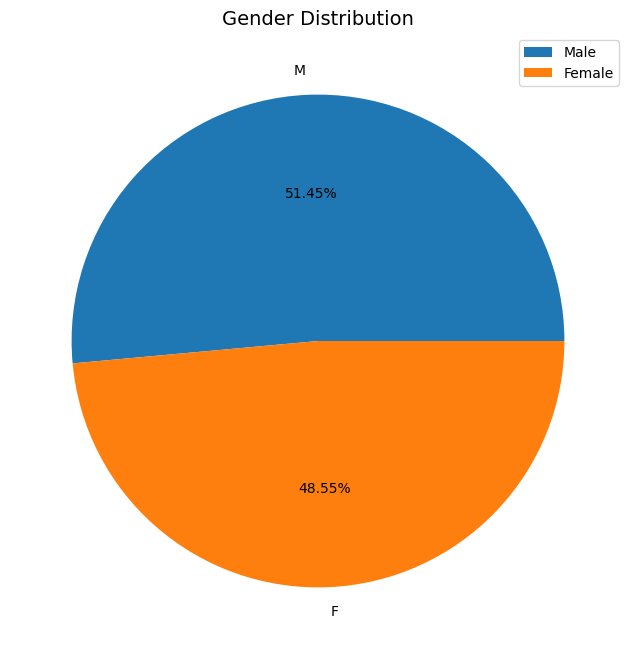

In [ ]:
gen_count=df["GENDER"].value_counts()
plt.figure(figsize=(10,8))
values=gen_count.values
labels=gen_count.index
plt.pie(values,labels=labels,autopct='%1.2f%%')
plt.title("Gender Distribution",fontsize='14')
plt.legend(["Male","Female"])
plt.show()

Text(0.5, 1.0, 'Gender Vs. Lung Cancer')

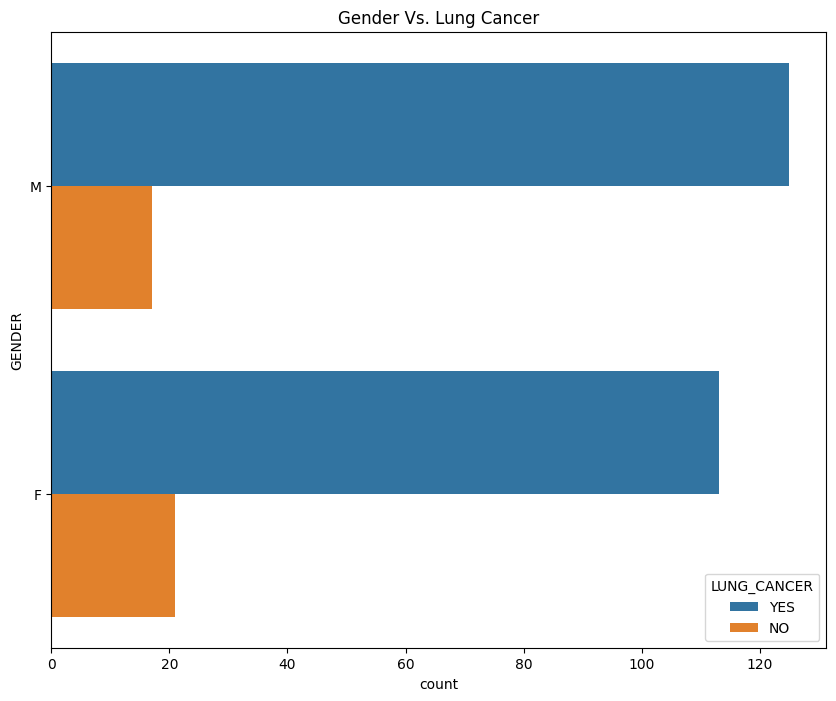

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(data=df,y="GENDER",hue="LUNG_CANCER")
plt.title("Gender Vs. Lung Cancer")

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df['GENDER'] = df['GENDER'].map({'F': 0, 'M': 1})

# scaler = MinMaxScaler()
# df['AGE'] = scaler.fit_transform(df[['AGE']])

df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,0,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,1,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,0,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [ ]:
lung_key = {'YES' : 1, 'NO' : 0}

df['LUNG_CANCER'] = df['LUNG_CANCER'].map(lung_key)
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1
2,0,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0
3,1,63,2,2,2,1,1,1,1,1,2,1,1,2,2,0
4,0,63,1,2,1,1,1,1,1,2,1,2,2,1,1,0


<Axes: >

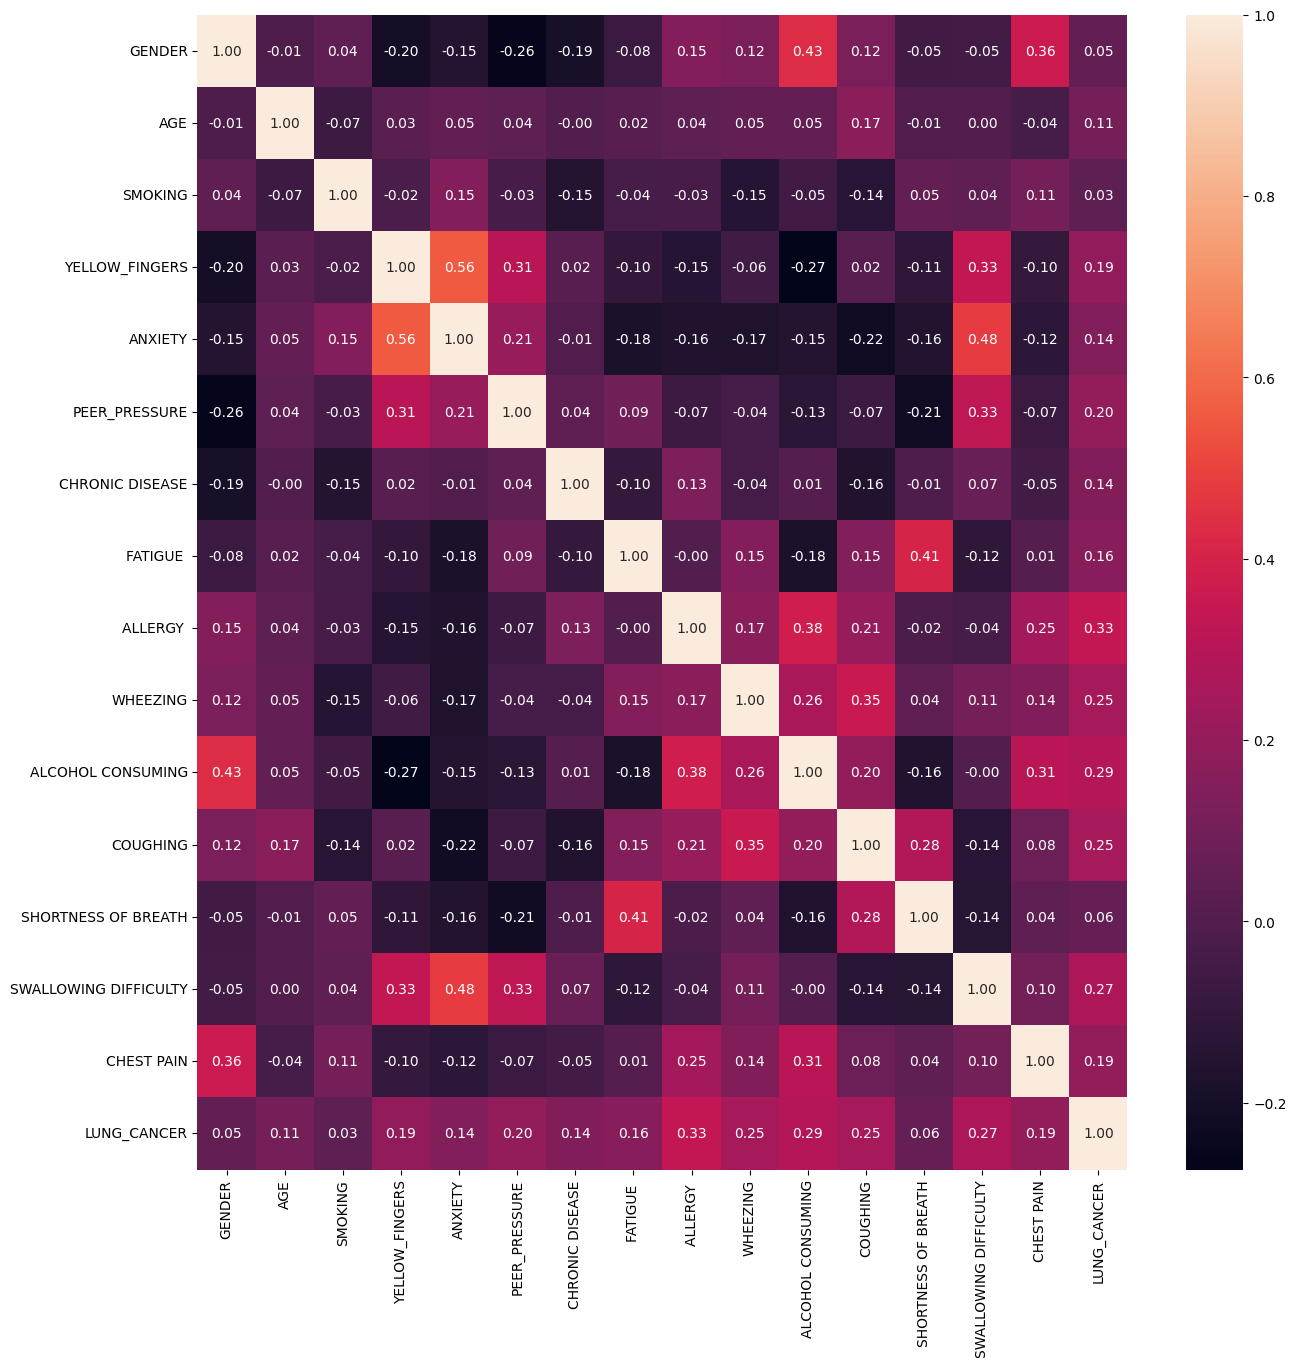

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True,fmt='0.2f')

In [ ]:
# split data
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
y

array([1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1])

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
age_index = 1

X_train_age = X_train[:, age_index].reshape(-1, 1)
X_test_age = X_test[:, age_index].reshape(-1, 1)


In [ ]:
X_train[:, age_index]

array([60, 38, 67, 55, 62, 59, 56, 65, 75, 77, 71, 66, 69, 62, 62, 73, 59,
       56, 68, 58, 71, 52, 62, 72, 52, 67, 74, 56, 55, 72, 73, 59, 47, 72,
       62, 55, 67, 64, 64, 77, 56, 55, 63, 57, 59, 78, 60, 59, 61, 76, 69,
       79, 55, 61, 54, 58, 71, 71, 61, 58, 55, 56, 65, 67, 62, 57, 75, 56,
       63, 72, 72, 67, 71, 67, 60, 74, 60, 59, 53, 64, 59, 63, 60, 70, 65,
       63, 64, 77, 63, 61, 87, 64, 44, 69, 64, 64, 56, 61, 64, 60, 60, 69,
       59, 54, 72, 59, 71, 69, 55, 63, 53, 56, 70, 63, 57, 56, 62, 70, 54,
       61, 59, 62, 68, 64, 74, 70, 64, 68, 68, 51, 47, 60, 78, 70, 54, 60,
       60, 67, 64, 48, 49, 68, 75, 52, 70, 64, 70, 63, 60, 49, 56, 74, 63,
       60, 60, 61, 58, 55, 59, 69, 51, 72, 74, 77, 68, 71, 81, 61, 54, 55,
       68, 58, 69, 67, 71, 57, 56, 67, 46, 67, 64, 77, 70, 68, 57, 53, 56,
       64, 64, 59, 51, 69, 77, 69, 59, 56, 47, 62, 70, 62, 59, 58, 64, 68,
       63, 70, 74, 76, 64, 81, 62, 70, 70, 60, 44, 55, 66, 49, 77, 72])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

X_train_age_scaled = scaler.fit_transform(X_train_age)
X_test_age_scaled = scaler.transform(X_test_age)

X_train[:, age_index] = X_train_age_scaled.flatten()
X_test[:, age_index] = X_test_age_scaled.flatten()

In [ ]:
X_train.shape

(220, 15)

In [ ]:
def model_performance1(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    Epochs = [i+1 for i in range(len(tr_acc))]

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [ ]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(6, activation = 'relu'))
model.add(Dense(3, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'] )

history=model.fit(X_train,y_train, epochs= 10, batch_size = 4)

Epoch 1/10
55/55 [==============================] - 1s 2ms/step - loss: 0.4471 - accuracy: 0.8818
Epoch 2/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3483 - accuracy: 0.8818
Epoch 3/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3396 - accuracy: 0.8818
Epoch 4/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3378 - accuracy: 0.8818
Epoch 5/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3361 - accuracy: 0.8818
Epoch 6/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3353 - accuracy: 0.8818
Epoch 7/10
55/55 [==============================] - 0s 3ms/step - loss: 0.3350 - accuracy: 0.8818
Epoch 8/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3324 - accuracy: 0.8818
Epoch 9/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3315 - accuracy: 0.8818
Epoch 10/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3302 - accuracy: 0.8818


In [ ]:
loss, accuracy = model.evaluate(X_test,y_test, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {loss}')

Model Accuracy : 79%
Model Loss : 50%


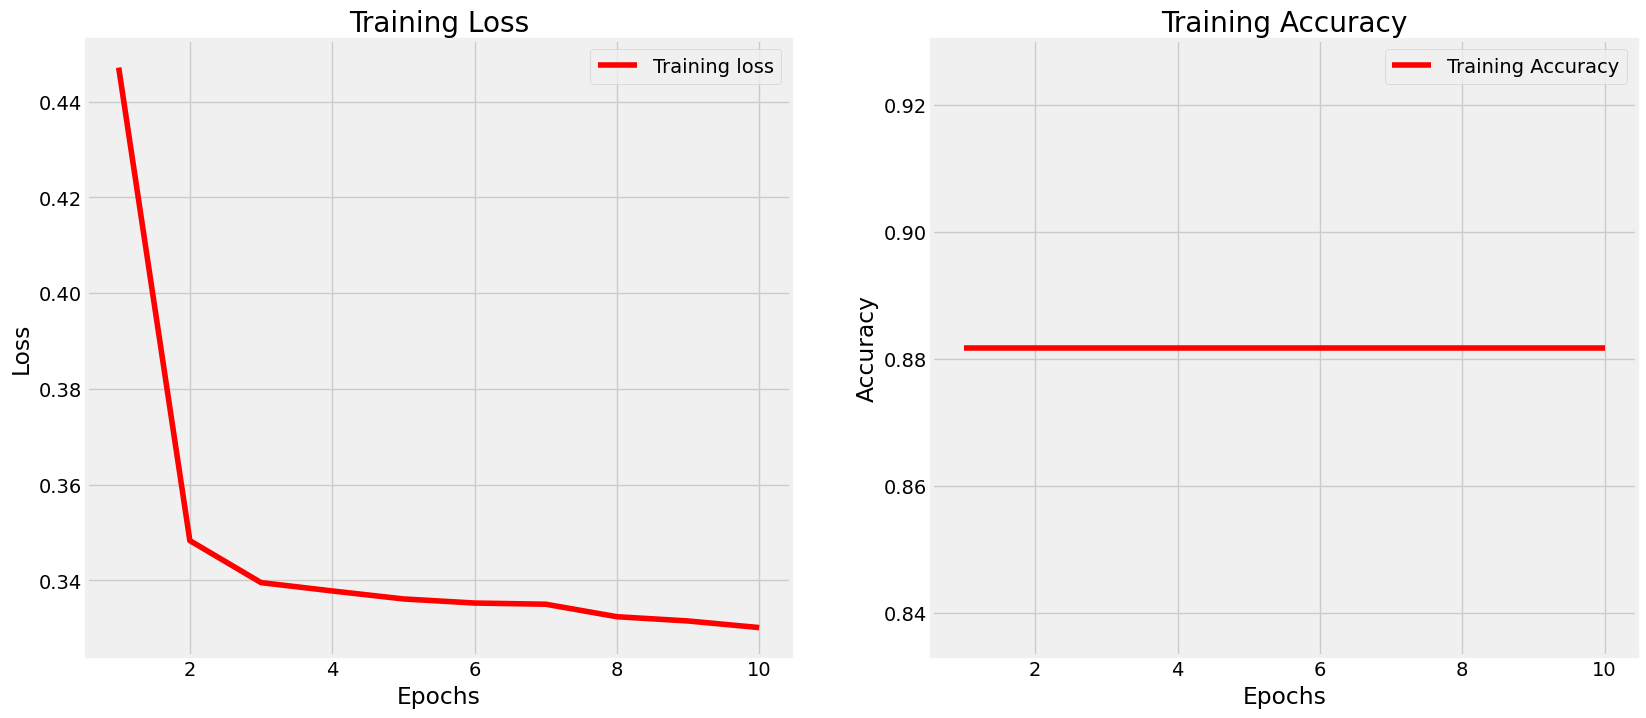

In [ ]:
model_performance1(history, 10)

In [ ]:
model1 = Sequential()
model1.add(Input(shape=(X_train.shape[1],)))
model1.add(Dense(10, activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(5, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))

model1.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'] )

history1=model1.fit(X_train,y_train, epochs= 10,batch_size = 4)

Epoch 1/10
55/55 [==============================] - 1s 2ms/step - loss: 0.5615 - accuracy: 0.6955
Epoch 2/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3786 - accuracy: 0.8636
Epoch 3/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3765 - accuracy: 0.8818
Epoch 4/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3514 - accuracy: 0.8818
Epoch 5/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3546 - accuracy: 0.8818
Epoch 6/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3655 - accuracy: 0.8818
Epoch 7/10
55/55 [==============================] - 0s 3ms/step - loss: 0.3609 - accuracy: 0.8818
Epoch 8/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3504 - accuracy: 0.8773
Epoch 9/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3439 - accuracy: 0.8773
Epoch 10/10
55/55 [==============================] - 0s 2ms/step - loss: 0.3549 - accuracy: 0.8818


In [ ]:
loss, accuracy = model1.evaluate(X_test,y_test, verbose=0)
print(f'Model Accuracy : {round(accuracy*100)}%')
print(f'Model Loss : {round(loss*100)}%')

Model Accuracy : 79%
Model Loss : 49%


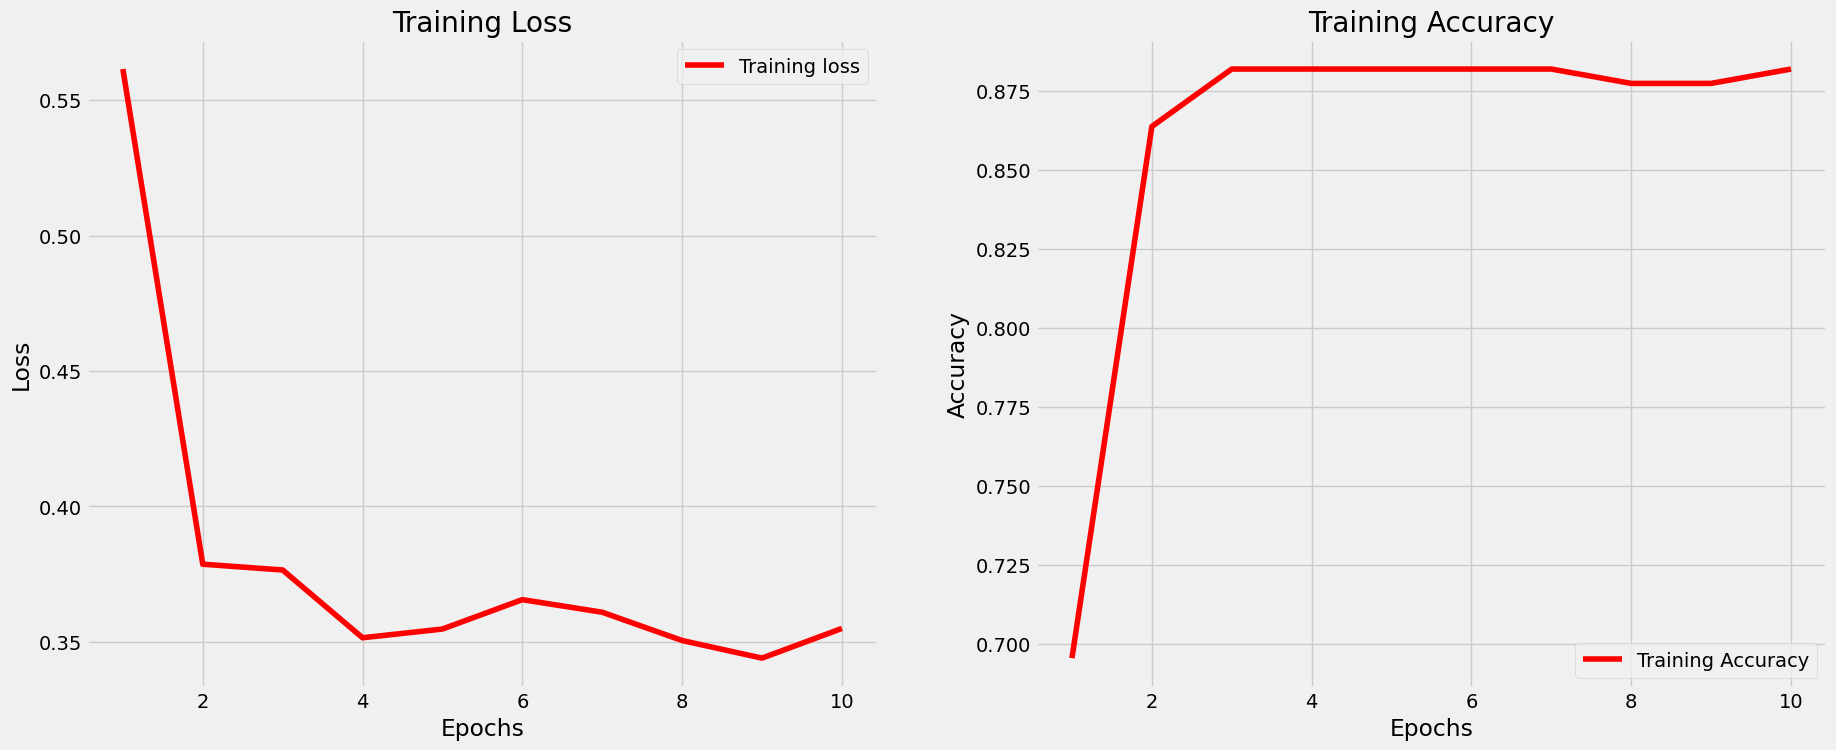

In [ ]:
model_performance1(history1, 10)